# Wind Turbine Power Generation Forecasting

Train dataset contains hourly meteorological data along with power output measurements collected between January 2013 and December 2016. The data includes variables such as temperature, relative humidity, wind speed at various altitudes, and power generated at different locations.

## Prepare workspace

1. Import dependencies.

In [1]:
import numpy as np
import pandas as pd
from sklearn.discriminant_analysis import StandardScaler

from lib.ml.layer.layer_def import Dense, Input
from lib.ml.util.loss_function import MEAN_SQUARED_ERROR
from lib.ml.model.seq_model import SeqNet, ValidationData
from lib.ml.optimizer.genetic_optimizer import GeneticOptimizer
from lib.ml.optimizer.gradient_descent_optimizer import GradientDescentOptimizer
from lib.ml.util.progress_tracker import NotebookProgressTracker

from lib.ml.util.activation_function import RELU_ACTIVATION
from src.data.wind_turbine.wind_turbine_dataset import (
    download_wind_turbine_dataset,
    process_wind_turbine_dataset,
    window_and_split,
)
from src.definitions import EXTERNAL_DATA_FOLDER
from src.visualization.plot import plot_loss_and_val_loss, plot_diff

2. Download and process `sudhanvahg/wind-turbine-power-generation-forecasting` dataset.

In [2]:
archive = download_wind_turbine_dataset(EXTERNAL_DATA_FOLDER)

3. Split on train/test/validate. Extract free and bound variables. Scale input.

In [3]:
scaler = StandardScaler()

dataset = process_wind_turbine_dataset(
    archive,
    scaler=scaler,
)

dataset.head(5)

,Temp_2m,RelHum_2m,DP_2m,WS_10m,WS_100m,WD_10m,WD_100m,WG_10m,Power,Location_1,Location_2,Location_3,Location_4
0,-0.804021,0.837857,-0.562194,-1.355386,-1.850563,-0.555885,-0.391588,-1.845008,0.151429,1.0,0.0,0.0,0.0
1,-0.808581,0.896680,-0.552661,-1.049536,-0.957421,-0.505925,-0.431150,-1.017793,0.133128,1.0,0.0,0.0,0.0
2,-0.881539,1.190795,-0.562194,-1.424449,-1.353283,-0.535901,-0.510276,-1.348679,0.114574,1.0,0.0,0.0,0.0
3,-0.854179,1.014326,-0.571727,-1.424449,-1.382727,-1.435186,-0.955355,-1.789861,0.095579,1.0,0.0,0.0,0.0
4,-0.858739,1.014326,-0.581260,-0.847281,-0.813472,-1.435186,-1.163059,-1.128089,0.076309,1.0,0.0,0.0,0.0


In [4]:
window_size = 12
train_val_split = 0.9

x_train, y_train, x_valid, y_valid, x_test, y_test = window_and_split(
    dataset=dataset, test_train_ratio=0.8, train_valid_ratio=0.9, window_size=12
)

print("x_train = " + str(x_train.shape))
print("y_train = " + str(y_train.shape))
print("x_valid = " + str(x_valid.shape))
print("y_valid = " + str(y_valid.shape))
print("x_test = " + str(x_test.shape))
print("y_test = " + str(y_test.shape))

validation_data = ValidationData(x_valid, y_valid)

x_train = (156, 100906)
y_train = (100906,)
x_valid = (156, 11212)
y_valid = (11212,)
x_test = (156, 28030)
y_test = (28030,)


## Train NN using genetic optimizer

1. Define neural network.

In [5]:
model = SeqNet(
    layers=[
        Input(x_train.shape[0]),
        Dense(64, activation_fun=RELU_ACTIVATION),
        Dense(1),
    ]
)

opt = GeneticOptimizer(
    population_size=200, mutation_rate=0.5, mutation_decay=0.005
)

compiled_model = model.compile(
    optimizer=opt,
    loss=MEAN_SQUARED_ERROR,
    progress_tracker=NotebookProgressTracker(),
)

2. Train neural network.

Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Train accuracy = 0.2521173504617343


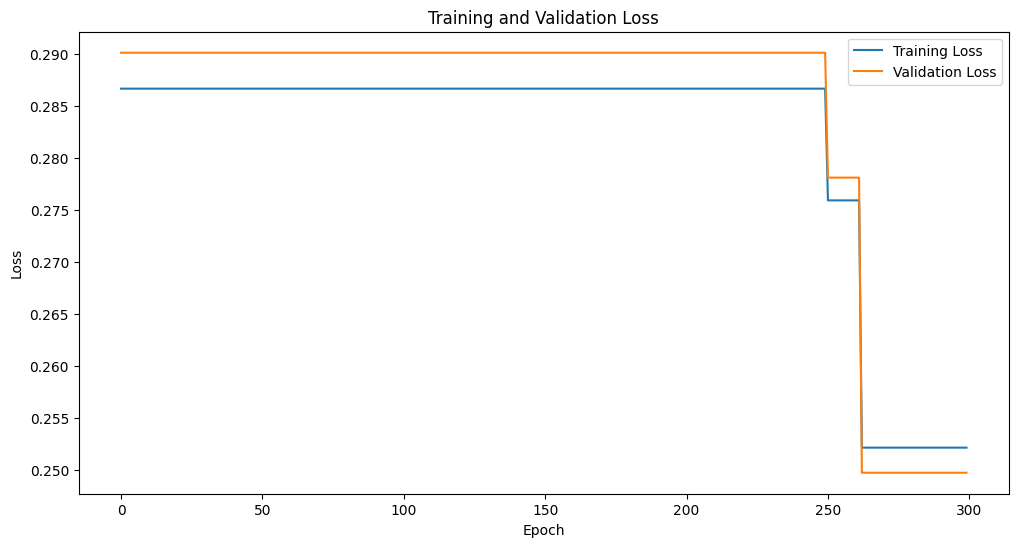

In [6]:
trained_model = compiled_model.fit(
    x_train, y_train, 300, validation_data=validation_data
)

print("Train accuracy = " + str(trained_model.train_loss()))

plot_loss_and_val_loss(trained_model)

3. Test neural network.

Test accuracy = 0.24695690055288347


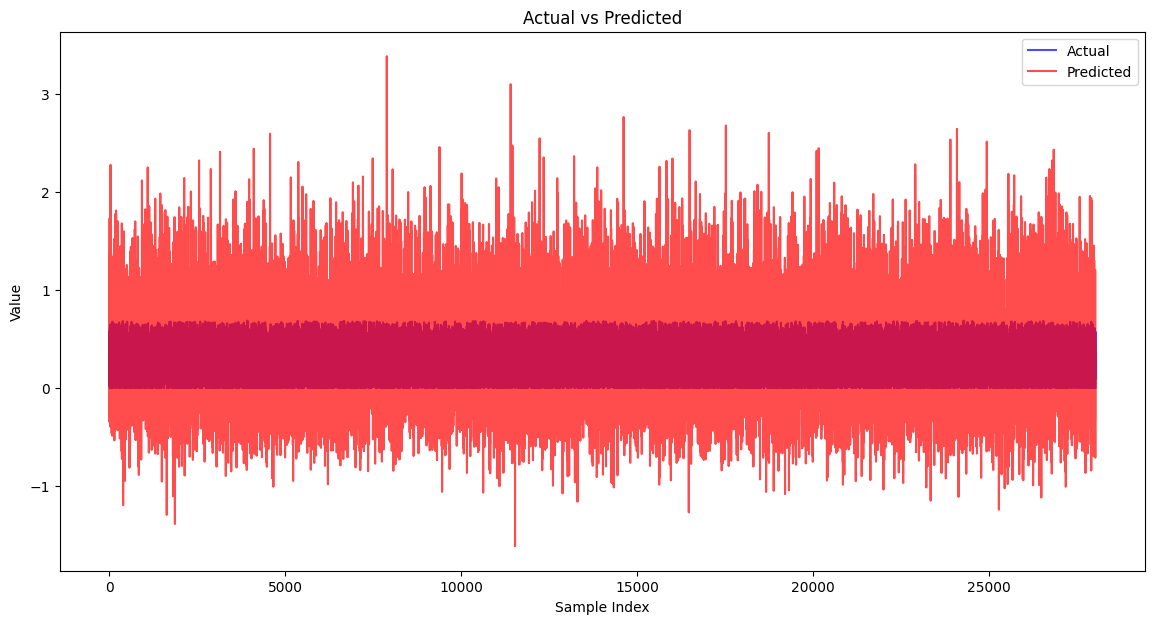

In [7]:
y_predicted = trained_model.predict(x_test)

print("Test accuracy = " + str(MEAN_SQUARED_ERROR.apply(y_test, y_predicted)))

plot_diff(y_test.flatten(), y_predicted.flatten())

4. Build report

In [8]:
delta = y_test - y_predicted

report = pd.DataFrame(
    {
        "Power RO": y_test.flatten(),
        "Power PO": y_predicted.flatten(),
        "DELTA": delta.flatten(),
        "DELTA^2": np.square(delta.flatten()),
    }
)

report_head = report.head(12)

display(report_head)

print("Delta total = " + str(report_head["DELTA"].sum()))
print("Delta^2 total = " + str(report_head["DELTA^2"].sum()))

,Power RO,Power PO,DELTA,DELTA^2
0,0.173866,0.290441,-0.116575,0.013590
1,0.065784,1.360071,-1.294287,1.675178
2,0.084981,0.416787,-0.331806,0.110096
3,0.177389,-0.281652,0.459042,0.210719
4,0.127862,0.303038,-0.175176,0.030687
5,0.221699,1.214982,-0.993283,0.986611
6,0.567582,0.109647,0.457934,0.209704
7,0.240980,-0.342267,0.583248,0.340178
8,0.410516,0.635967,-0.225451,0.050828
9,0.500106,0.442618,0.057488,0.003305


Delta total = -1.685077619974118
Delta^2 total = 3.8142328542822512


## Train NN using gradient descent optimizer

1. Define Neural network

In [13]:
model = SeqNet(
    layers=[
        Input(x_train.shape[0]),
        Dense(64, activation_fun=RELU_ACTIVATION),
        Dense(64, activation_fun=RELU_ACTIVATION),
        Dense(1),
    ]
)

opt = GradientDescentOptimizer(learning_rate=1e-4, momentum_decay=0.9)

compiled_model = model.compile(
    optimizer=opt,
    loss=MEAN_SQUARED_ERROR,
    progress_tracker=NotebookProgressTracker(),
)

2. Train neural network.

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Train accuracy = 0.24773142172884105


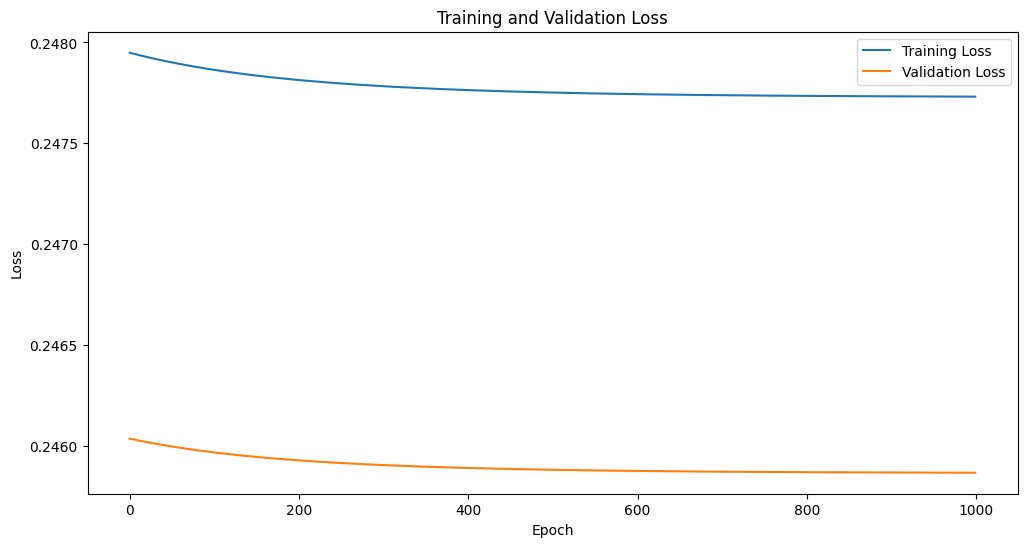

In [15]:
trained_model = compiled_model.fit(
    x_train, y_train, 1000, validation_data=validation_data
)

print("Train accuracy = " + str(trained_model.train_loss()))

plot_loss_and_val_loss(trained_model)

3. Test neural network.

Test accuracy = 0.24469721123382382


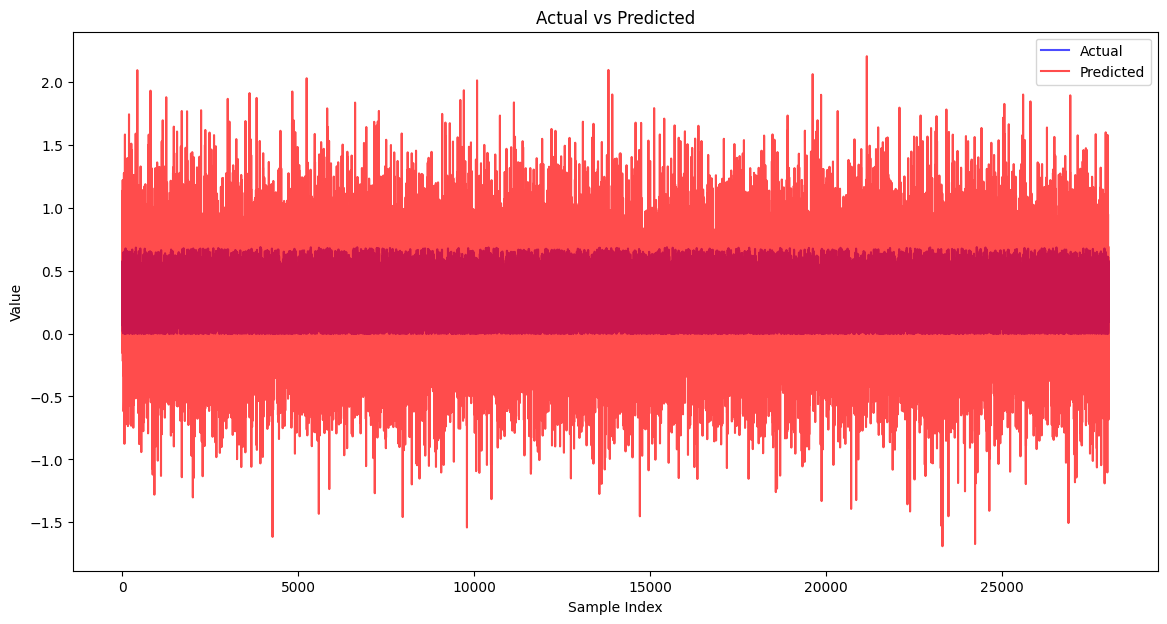

In [16]:
y_predicted = trained_model.predict(x_test)

print("Test accuracy = " + str(MEAN_SQUARED_ERROR.apply(y_test, y_predicted)))

plot_diff(y_test.flatten(), y_predicted.flatten())

4. Build report

In [17]:
delta = y_test - y_predicted

report = pd.DataFrame(
    {
        "Power RO": y_test.flatten(),
        "Power PO": y_predicted.flatten(),
        "DELTA": delta.flatten(),
        "DELTA^2": np.square(delta.flatten()),
    }
)

report_head = report.head(12)

display(report_head)

print("Delta total = " + str(report_head["DELTA"].sum()))
print("Delta^2 total = " + str(report_head["DELTA^2"].sum()))

,Power RO,Power PO,DELTA,DELTA^2
0,0.173866,0.688836,-0.514970,0.265194
1,0.065784,0.002975,0.062809,0.003945
2,0.084981,0.680207,-0.595226,0.354294
3,0.177389,0.295302,-0.117913,0.013903
4,0.127862,-0.153857,0.281718,0.079365
5,0.221699,0.376387,-0.154688,0.023928
6,0.567582,0.530008,0.037573,0.001412
7,0.240980,0.952968,-0.711987,0.506926
8,0.410516,-0.132617,0.543134,0.294994
9,0.500106,0.365574,0.134531,0.018099


Delta total = -0.37566165463342815
Delta^2 total = 1.7796098956642197
